In [23]:
from copy import deepcopy
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import tensorboard as tb
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformer_lens import HookedTransformerConfig, HookedTransformer

from mats2025_application.utils import Mess3
from mats2025_application.data import Mess3Dataset, compute_activations_for_all_subsequences
from mats2025_application.experiment_utils import train_mess3, barycentric_to_cartesian

In [24]:
%load_ext tensorboard

## Setup

In [ ]:
EXPERIMENT_PARAMS = SimpleNamespace(
    seed = 0,
    device="mps",
    log_dir="mats2025-application/tb_logs/",
    checkpoint_dir="mats2025-applications/checkpoints"
)

MESS3_NET_PARAMS = SimpleNamespace( 
    lr = .01, 
    batch_size = 1000,
    n_train_seq = 60000000,
    n_valid_seq = 1000,
    n_test_seq = 50000,
    weight_decay=0.,
)

BELIEF_NET_PARAMS = SimpleNamespace(
    lr = .01, 
    batch_size = 64,
    n_epochs = 2,
    weight_decay=0.,
)

MODEL_PARAMS = HookedTransformerConfig(
    n_ctx = 10,
    n_layers = 4,
    d_model = 64,
    d_head = 8,
    n_heads = 1,
    d_mlp = 256,
    attn_only=False,
    act_fn="relu",
    attention_dir="causal",
    d_vocab=3,
    default_prepend_bos=False
)

MESS3_PARAMS = SimpleNamespace( 
    x = .05,
    a = .85
)

np.random.seed(EXPERIMENT_PARAMS.seed)
torch.manual_seed(EXPERIMENT_PARAMS.seed)
torch.cuda.manual_seed_all(EXPERIMENT_PARAMS.seed)


## Create Mess3 Data

In [3]:
# train_dset_params = deepcopy(DSET_PARAMS)
# valid_dset_params = deepcopy(DSET_PARAMS)

# train_dset_params.n_seq = MESS3_NET_PARAMS.n_train_seq
# valid_dset_params.n_seq = MESS3_NET_PARAMS.n_valid_seq

mess3 = Mess3(**vars(MESS3_PARAMS))

In [4]:
mess3.msp = mess3.derive_mixed_state_presentation(depth=MODEL_PARAMS.n_ctx+1)
mess3_train = Mess3Dataset(mess3, MODEL_PARAMS.n_ctx, MESS3_NET_PARAMS.n_train_seq)
mess3_valid = Mess3Dataset(mess3, MODEL_PARAMS.n_ctx, MESS3_NET_PARAMS.n_valid_seq)
mess3_test = Mess3Dataset(mess3, MODEL_PARAMS.n_ctx, MESS3_NET_PARAMS.n_test_seq, return_belief_dist=True)

# train, valid, test = random_split(mess3, [.7, .2, .1])
train_loader = DataLoader(mess3_train, batch_size=MESS3_NET_PARAMS.batch_size)
valid_loader = DataLoader(mess3_valid, batch_size=MESS3_NET_PARAMS.batch_size)

### Check Mess3 has transition matrices matching pg. 14 in Appendix

In [5]:
assert np.array_equal(mess3_train.transition_matrix, mess3_valid.transition_matrix) and np.array_equal(mess3_valid.transition_matrix, mess3_train.transition_matrix)
mess3_train.transition_matrix

array([[[0.765  , 0.00375, 0.00375],
        [0.0425 , 0.0675 , 0.00375],
        [0.0425 , 0.00375, 0.0675 ]],

       [[0.0675 , 0.0425 , 0.00375],
        [0.00375, 0.765  , 0.00375],
        [0.00375, 0.0425 , 0.0675 ]],

       [[0.0675 , 0.00375, 0.0425 ],
        [0.00375, 0.0675 , 0.0425 ],
        [0.00375, 0.00375, 0.765  ]]])

### Setup model & training

In [6]:
model = HookedTransformer(MODEL_PARAMS)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=MESS3_NET_PARAMS.lr,
                            weight_decay=MESS3_NET_PARAMS.weight_decay)
loss_func = torch.nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir=EXPERIMENT_PARAMS.log_dir, flush_secs=5)

In [8]:
train_mess3(model, optimizer, loss_func, EXPERIMENT_PARAMS, writer, train_loader, valid_loader)

Validation loss @ batch 0: 1.0865049362182617
Validation loss @ batch 100: 0.8329392671585083
Validation loss @ batch 200: 0.8032599687576294
Validation loss @ batch 300: 0.8168419003486633
Validation loss @ batch 400: 0.8282586932182312
Validation loss @ batch 500: 0.8088563680648804
Validation loss @ batch 600: 0.8165746927261353
Validation loss @ batch 700: 0.8269939422607422
Validation loss @ batch 800: 0.824134349822998
Validation loss @ batch 900: 0.8128262758255005
Validation loss @ batch 1000: 0.8210763931274414
Validation loss @ batch 1100: 0.8226994276046753
Validation loss @ batch 1200: 0.8196004033088684
Validation loss @ batch 1300: 0.8163858652114868
Validation loss @ batch 1400: 0.8158273696899414
Validation loss @ batch 1500: 0.8117508888244629
Validation loss @ batch 1600: 0.8145185112953186
Validation loss @ batch 1700: 0.79770827293396
Validation loss @ batch 1800: 0.8002219200134277
Validation loss @ batch 1900: 0.8169360160827637
Validation loss @ batch 2000: 0.806

In [ ]:
%tensorboard --logdir mats2025-application/tb_logs

Reusing TensorBoard on port 6007 (pid 29987), started 0:00:26 ago. (Use '!kill 29987' to kill it.)

In [ ]:
fname = f"mess3_bs={MESS3_NET_PARAMS.batch_size}_ntrain={MESS3_NET_PARAMS.n_train_seq}.th"

In [ ]:
torch.save(model.state_dict(), fname)

## Analyze belief states

In [ ]:
fname = f"mess3_bs={MESS3_NET_PARAMS.batch_size}_ntrain={MESS3_NET_PARAMS.n_train_seq}.th"

In [ ]:
# Load checkpoint if needed
model = HookedTransformer(MODEL_PARAMS)
model.load_state_dict(torch.load(fname, weights_only=True))

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [ ]:
mess3_test.reset_counter()
test_seq, true_beliefs = mess3_test.generate_histories_with_beliefs()
subseq_activ = compute_activations_for_all_subsequences(model, test_seq, EXPERIMENT_PARAMS.device)
print(test_seq.shape)
print(true_beliefs.shape)
print(subseq_activ.shape)

Moving model to device:  mps
torch.Size([50000, 10])
(500000, 3)
(500000, 64)


#### Train linear readout to predict beliefs after layer norm

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(subseq_activ, true_beliefs)
pred_beliefs = lin_reg.predict(subseq_activ)

(500000, 3)

In [ ]:
# Clip values to [0,1] for plotting
normalized_pred_beliefs = pred_beliefs.copy()
normalized_pred_beliefs[normalized_pred_beliefs < 0.] = 0.
normalized_pred_beliefs[normalized_pred_beliefs > 1.] = 1.

In [ ]:
# Examine MSE
torch.nn.functional.mse_loss(torch.tensor(pred_beliefs),
                             torch.tensor(true_beliefs),
                             reduction="mean")

tensor(0.0019, dtype=torch.float64)

### Visualize simplex result

In [21]:
proj_gt = barycentric_to_cartesian(true_beliefs)
proj_pred = barycentric_to_cartesian(normalized_pred_beliefs)

Text(0.5, 1.0, 'Ground Truth Belief Geometry')

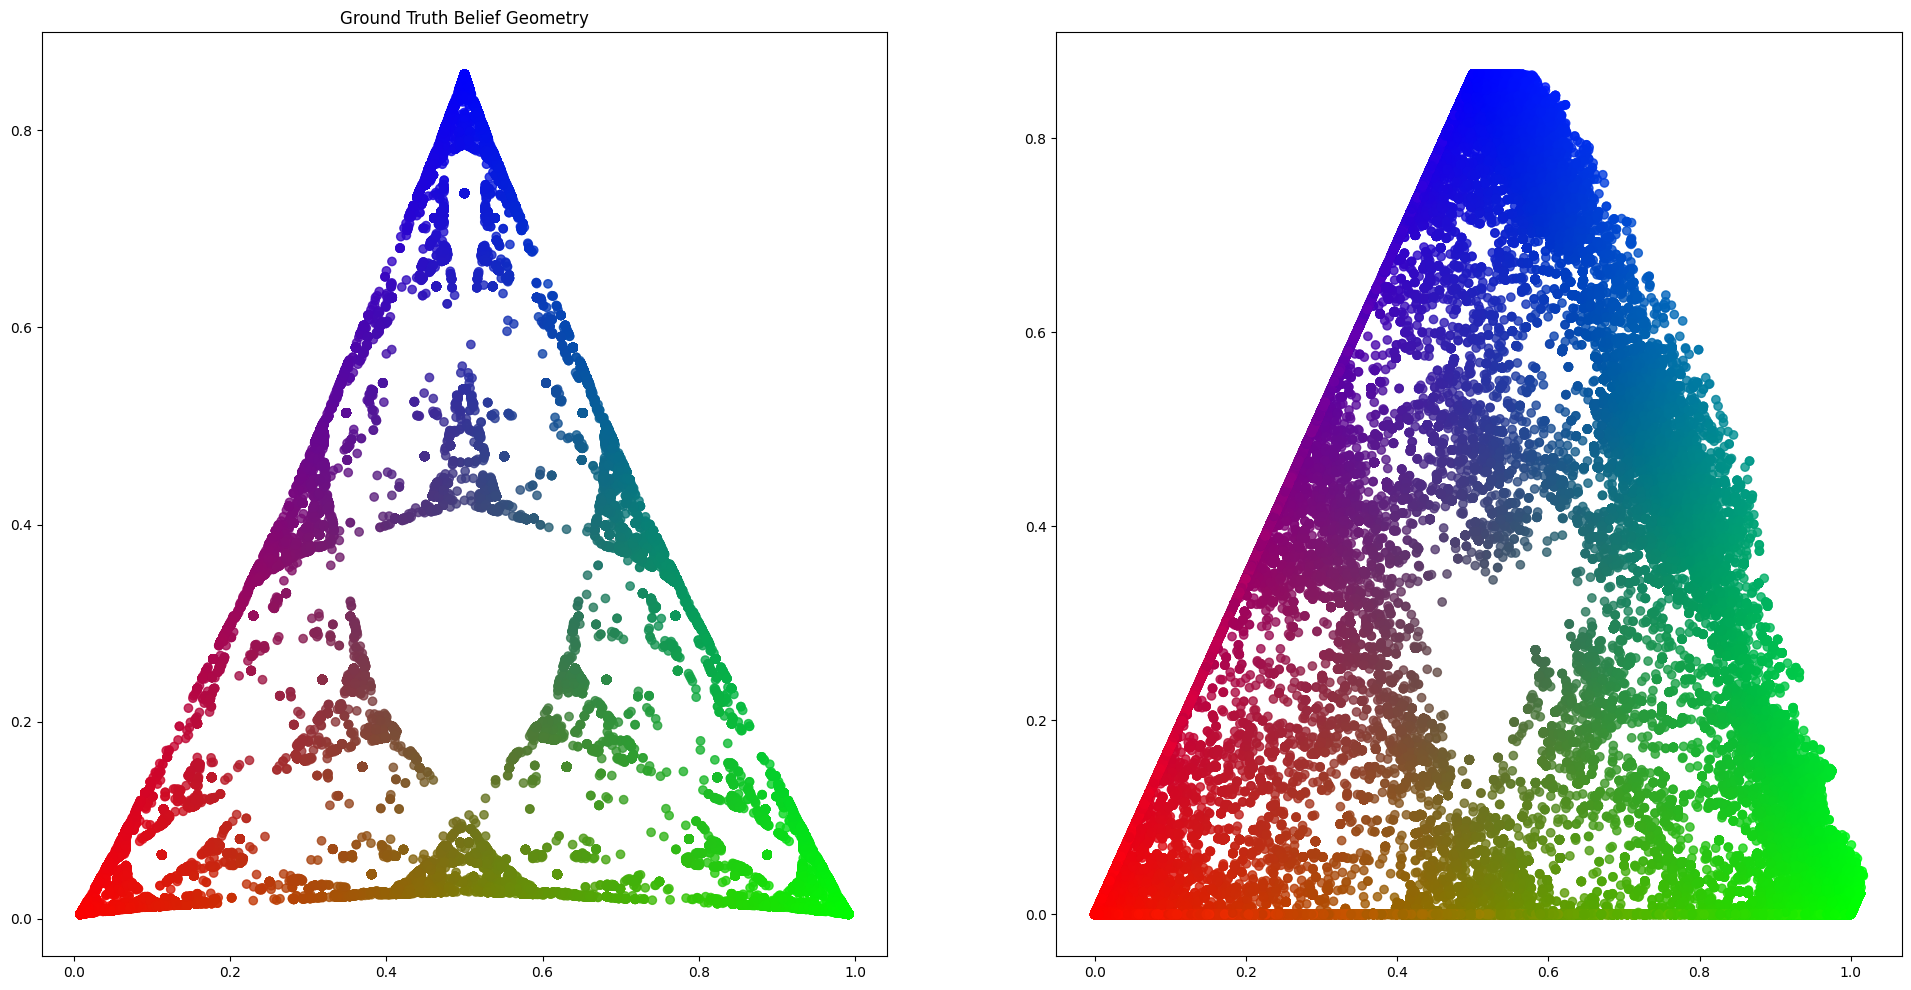

In [34]:
# Plotting
fig, (ax_gt, ax_pred) = plt.subplots(1, 2, figsize=(24, 12))

# Ground Truth
ax_gt.scatter(proj_gt[:, 0], proj_gt[:, 1], c=true_beliefs, alpha=0.8)
ax_pred.scatter(proj_pred[:, 0], proj_pred[:, 1], c=normalized_pred_beliefs, alpha=0.8)
ax_gt.set_title('Ground Truth Belief Geometry')

## Old plot with less training

Text(0.5, 1.0, 'Ground Truth Belief Geometry')

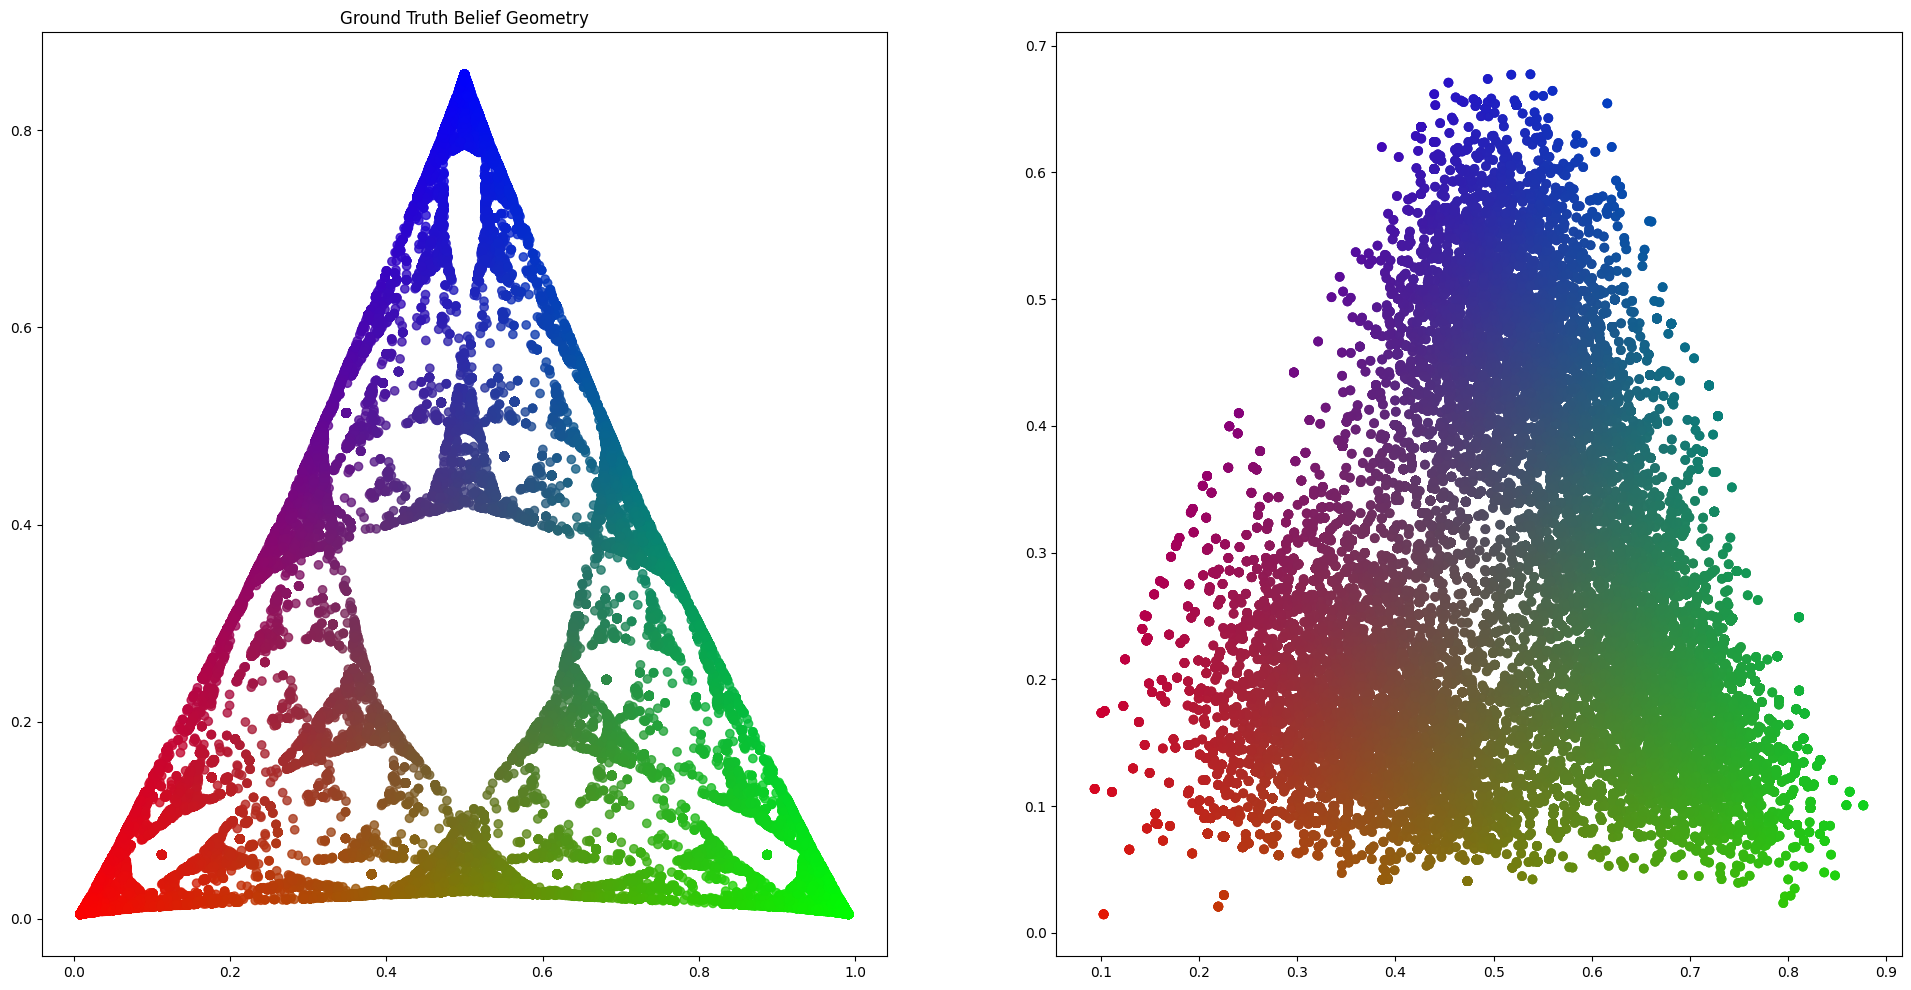

In [ ]:
# Plotting
fig, (ax_gt, ax_pred) = plt.subplots(1, 2, figsize=(24, 12))

# Ground Truth
ax_gt.scatter(proj_gt[:, 0], proj_gt[:, 1], c=true_beliefs, alpha=0.8)
ax_pred.scatter(proj_pred[:, 0], proj_pred[:, 1], c=normalized_pred_beliefs, alpha=0.8)
ax_gt.set_title('Ground Truth Belief Geometry')